## Modelagem de topicos através do tempo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import unicodedata
from umap import UMAP
from hdbscan import HDBSCAN
import os
import numpy as np

[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
comments = pd.read_csv("comments_filtered.csv")
print(comments[['created_timestamp_utc']].head())
comments['month'] = pd.to_datetime(comments['created_timestamp_utc']).dt.to_period('M').astype(str)
comments['type'] = 'C'

date_month_com = comments['month']

  created_timestamp_utc
0   2022-01-01 19:16:14
1   2022-01-01 19:16:20
2   2022-01-01 20:33:19
3   2022-01-01 23:30:43
4   2022-01-02 01:08:38


In [3]:
submissions = pd.read_csv("submissions_filtered.csv")
print(submissions[['created_timestamp_utc']].head())
submissions['month'] = pd.to_datetime(submissions['created_timestamp_utc']).dt.to_period('M').astype(str)
submissions['type'] = 'S'

date_month_sub = submissions['month']

  created_timestamp_utc
0   2022-01-13 11:42:41
1   2022-01-18 17:36:20
2   2022-01-19 02:58:23
3   2022-01-19 21:07:55
4   2022-01-22 13:39:24


In [4]:
# concatenate the two numpy arrays
date_month = pd.concat([date_month_com, date_month_sub], ignore_index=True)

print(date_month.value_counts().sort_index())


month
2022-01    1077
2022-02    9436
2022-03    9458
2022-04    2158
2022-05    2944
2022-06    1480
2022-07    1513
2022-08    1036
2022-09    2166
2022-10    2627
2022-11    2204
2022-12    1484
Name: count, dtype: int64


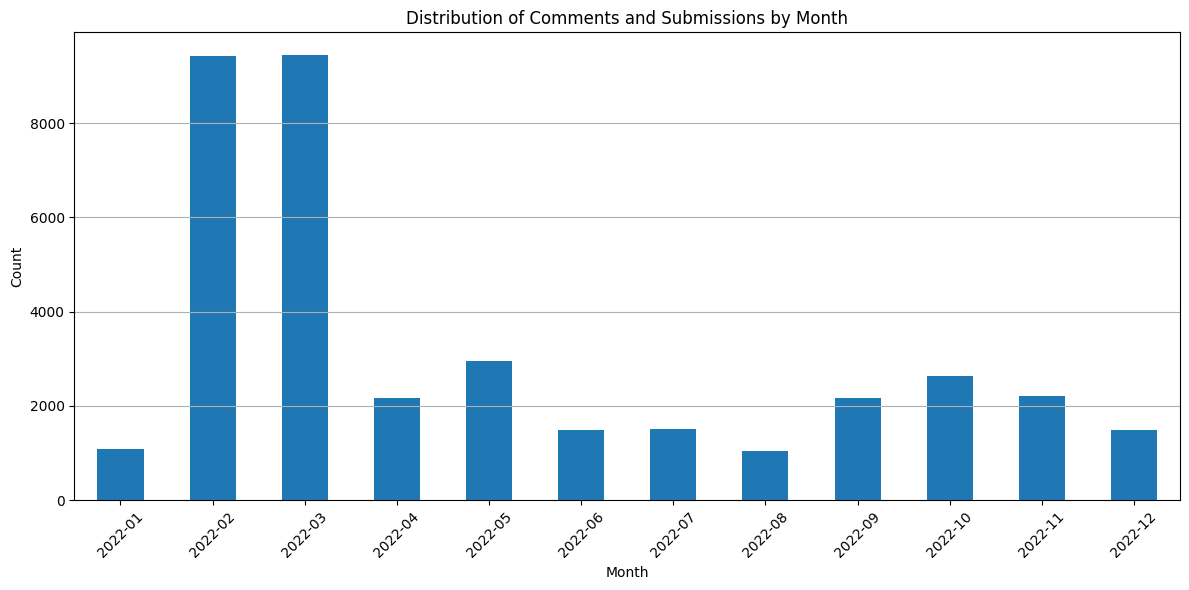

In [5]:
# plot distribution of comments and submissions by month 
date_month.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Comments and Submissions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [6]:
data_comments = comments[['id', 'body', 'month', 'type']].rename(columns={'body': 'text', 'month': 'date'})
print(data_comments.head())
print(data_comments.shape)
data_submissions = submissions[['id', 'selftext', 'month', 'type']].rename(columns={'selftext': 'text', 'month': 'date'})
print(data_submissions.head())
print(data_submissions.shape)

# concatenate the two dataframes
data = pd.concat([data_comments, data_submissions], ignore_index=True)
data.columns = ['id', 'text', 'month', 'type']
print(data.head())
print(data.shape)

        id                                               text     date type
0  hqu6678  Eu não coloco a tua experiência em causa, mas ...  2022-01    C
1  hqu66rn  &gt;Farmaajo tem sido apoiado por muito tempo ...  2022-01    C
2  hquhhht  O que é dar certo? Porque pensa bem, o país er...  2022-01    C
3  hqv6rub  O embargo é dos EUA. Eles podem fazer negócios...  2022-01    C
4  hqvk4xj  a Ucrânia voltar ao seu estado natural de naçã...  2022-01    C
(36854, 4)
       id                                               text     date type
0  s2xl48  Conclamo meus colegas redditors a ouvirem/vere...  2022-01    S
1  s72yze  \- Apoio a Russia. Lutaria se pedissem.   \n\-...  2022-01    S
2  s7fnwt  Olhem o vídeo, por exemplo, de uma matéria fal...  2022-01    S
3  s80kun   Só pra saber q eu n sou o único vendo isso!? ...  2022-01    S
4  sa2q4t  Na internet já vi vários comentários de ucrani...  2022-01    S
(729, 4)
        id                                               text    month typ

In [7]:
print(stopwords.words('portuguese')[:30])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles']


### Pre-process

In [8]:
def preprocess_text(text):
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    
    ### normaliza acentos (ê → e, õ → o, etc)
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")
    
    ### remove tudo que não seja letra ou número
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    return text.strip()

data['text'] = data['text'].apply(preprocess_text)

### Pre-calculate embeddings

In [ ]:
docs = data['text'].tolist()
timestamps = data['month'].tolist()

embeddings_path = "embeddings.npy"

if os.path.exists(embeddings_path):
    embeddings = np.load(embeddings_path)
    print("Embeddings carregadas do disco.")
else:
    embedding_model = SentenceTransformer("PORTULAN/serafim-100m-portuguese-pt-sentence-encoder")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    np.save(embeddings_path, embeddings)
    print("Embeddings calculadas e salvas no disco.")

Batches:   0%|          | 0/1175 [00:00<?, ?it/s]

### Stopwords and vectorizer

In [61]:
stopwords_pt = list(stopwords.words("portuguese"))
# apply the same preprocessing to the stopwords
stopwords_pt = [preprocess_text(word) for word in stopwords_pt]
stopwords_en = list(stopwords.words("english"))
my_stopwords = ['pra', 'gt', 'vai', 'ta', 'pq', 'vc']
final_stopwords = stopwords_pt + stopwords_en + my_stopwords


vectorizer = CountVectorizer(
    ngram_range=(1,2), 
    stop_words=final_stopwords,
    max_df=0.8,
    min_df=1
)

### UMAP Dimension Reduction

In [50]:
umap_model = UMAP(
    n_neighbors=15, 
    n_components=10, 
    min_dist=0.0, 
    metric='cosine', 
    random_state=13
)

### HDBSCAN clustering

In [55]:
hdbscan_model = HDBSCAN(
    min_cluster_size=500, 
    metric='euclidean', 
    cluster_selection_method='eom', 
    prediction_data=True, 
)

In [62]:
topic_model = BERTopic(
    vectorizer_model=vectorizer, 
    calculate_probabilities=True, 
    umap_model=umap_model,
    hdbscan_model= hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2025-07-02 21:52:49,080 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2025-07-02 21:53:31,352 - BERTopic - Dimensionality - Completed ✓
2025-07-02 21:53:31,355 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 21:53:46,910 - BERTopic - Cluster - Completed ✓
2025-07-02 21:53:46,924 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 21:53:56,842 - BERTopic - Representation - Completed ✓


In [64]:
### value counts of topics
print(pd.Series(topics).value_counts().sort_index())

-1    20646
 0    11759
 1     2485
 2     2186
 3      507
Name: count, dtype: int64


In [65]:
topic_model.visualize_barchart()

In [ ]:
filtrar = False

if filtrar:

    for i in range(len(topics)):
        # exclude lines that are in topics [-1, 1, 3, 4, 5, 6]
        if topics[i] in [-1, 1, 3, 4, 5, 6]:
            
            if data['type'][i] == 'C':
                comments = comments[comments['id'] != data['id'][i]]   
            else:
                submissions = submissions[submissions['id'] != data['id'][i]]

    comments.to_csv("comments_filtered2.csv", index=False)
    submissions.to_csv("submissions_filtered2.csv", index=False)
           

                

In [59]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

0it [00:00, ?it/s]

12it [04:08, 20.74s/it]


In [60]:
topic_model.visualize_topics_over_time(topics_over_time)